# FRAMEWORK to SPOT-CHECK Machine Learning Algorithms

References: ["How to Develop a Framework to Spot-Check Machine Learning Algorithms in Python"](https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/)

Spot-checking algorithms is a technique in applied machine learning designed to quickly and objectively provide a first set of results on a new predictive modeling problem.

## for CLASSIFICATION (with Iris dataset)

### Framework:
- Load Dataset
- Define Models
    - Linear Models.
    - Nonlinear Models.
    - Ensemble Models.
- Evaluate Models
- Summarize Results

### Framework Extensions:
- Course Grid Search for Gradient Boosting: Gradient Boosting with Grid Search hiper-parameters optimization.
- Repeated Evaluations: Specially for cases when there are not too much data (it is not possible increase nfolks) and scores have too much variability.
- Varied Input Representations:
    - Without pre-processing.
    - With only standarization.
    - With only normalization.
    - With standarization and normalization.


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# other libraries
import pandas as pd
from datetime import datetime

In [9]:
# load the dataset, returns X and y elements
def load_dataset():
    path = 'https://raw.githubusercontent.com/jmquintana79/Datasets/master/iris.csv'
    df = pd.read_csv(path, header = None)
    col_x = ['x1','x2','x3','x4']; col_y = ['y']
    df.columns = col_x + col_y
    dconverter = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
    df['y'] = df['y'].apply(lambda x: dconverter[x])
    return df[col_x].values, df[col_y[0]].values

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# define gradient boosting models
def define_gbm_models(models=dict(), use_xgb=True):
	# define config ranges
	rates = [0.001, 0.01, 0.1]
	trees = [50, 100]
	ss = [0.5, 0.7, 1.0]
	depth = [3, 7, 9]
	# add configurations
	for l in rates[:]:
		for e in trees[:]:
			for s in ss[:]:
				for d in depth[:]:
					cfg = [l, e, s, d]
					if use_xgb:
						name = 'xgb-' + str(cfg)
						models[name] = XGBClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
					else:
						name = 'gbm-' + str(cfg)
						models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
	print('Defined %d models' % len(models))
	return models


# no transforms pipeline
def pipeline_none(model):
	return model

# standardize transform pipeline
def pipeline_standardize(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# normalize transform pipeline
def pipeline_normalize(model):
	steps = list()
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# standardize and normalize pipeline
def pipeline_std_norm(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline


# evaluate a single model
def evaluate_model(X, y, model, folds, repeats, metric, pipe_func):
	# create the pipeline
	pipeline = pipe_func(model)
	# evaluate model
	scores = list()
	# repeat model evaluation n times
	for _ in range(repeats):
		# perform run
		scores_r = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
		# add scores to list
		scores += scores_r.tolist()
	return scores


# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, repeats, metric, pipe_func, verbose = False):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, repeats, metric, pipe_func)
    except:
        scores = None
        if verbose:
            print(f'[evaluation] {e}')        
    return scores


# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, pipe_funcs, folds=10, repeats=3, metric='f1_macro'):
	results = dict()
	for name, model in models.items():
		# evaluate model under each preparation function
		for i in range(len(pipe_funcs)):
			# evaluate the model
			scores = robust_evaluate_model(X, y, model, folds, repeats, metric, pipe_funcs[i], verbose = True)
			# update name
			run_name = str(i) + name
			# show process
			if scores is not None:
				# store a result
				results[run_name] = scores
				mean_score, std_score = mean(scores), std(scores)
				print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
			else:
				print('>%s: error' % run_name)
	return results


# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10, is_plot = True):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = mean(results[name]), std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
    # boxplot for the top n
    if is_plot:
        pyplot.boxplot(scores, labels=names)
        _, labels = pyplot.xticks()
        pyplot.setp(labels, rotation=90)
        pyplot.savefig('spotcheck.png')


Defined 53 models
Defined 107 models
>0logistic: 0.973 (+/-0.033)
>1logistic: 0.960 (+/-0.062)
>2logistic: 0.917 (+/-0.070)
>3logistic: 0.917 (+/-0.070)
>0ridge-0.1: 0.816 (+/-0.095)
>1ridge-0.1: 0.816 (+/-0.095)
>2ridge-0.1: 0.816 (+/-0.095)
>3ridge-0.1: 0.816 (+/-0.095)
>0ridge-0.2: 0.816 (+/-0.095)
>1ridge-0.2: 0.816 (+/-0.095)
>2ridge-0.2: 0.823 (+/-0.100)
>3ridge-0.2: 0.823 (+/-0.100)
>0ridge-0.3: 0.823 (+/-0.100)
>1ridge-0.3: 0.816 (+/-0.095)
>2ridge-0.3: 0.836 (+/-0.096)
>3ridge-0.3: 0.836 (+/-0.096)
>0ridge-0.4: 0.823 (+/-0.100)
>1ridge-0.4: 0.816 (+/-0.095)
>2ridge-0.4: 0.844 (+/-0.089)
>3ridge-0.4: 0.844 (+/-0.089)
>0ridge-0.5: 0.823 (+/-0.100)
>1ridge-0.5: 0.816 (+/-0.095)
>2ridge-0.5: 0.850 (+/-0.093)
>3ridge-0.5: 0.850 (+/-0.093)
>0ridge-0.6: 0.823 (+/-0.100)
>1ridge-0.6: 0.816 (+/-0.095)
>2ridge-0.6: 0.843 (+/-0.094)
>3ridge-0.6: 0.843 (+/-0.094)
>0ridge-0.7: 0.823 (+/-0.100)
>1ridge-0.7: 0.816 (+/-0.095)
>2ridge-0.7: 0.843 (+/-0.094)
>3ridge-0.7: 0.843 (+/-0.094)
>0ridge

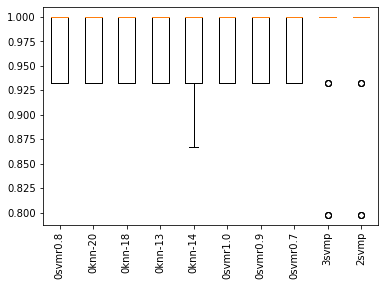

In [10]:
# initial time
tic = datetime.now()
# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# add gbm models with grid search hiperparameters optimization
models = define_gbm_models(models, use_xgb=False)
# define transform pipelines
pipelines = [pipeline_none, pipeline_standardize, pipeline_normalize, pipeline_std_norm]
# evaluate models
results = evaluate_models(X, y, models, pipelines, repeats=3)
# summarize results
summarize_results(results, top_n=10)
# final time
toc = datetime.now()
# time spent
tictoc = ((toc-tic).seconds)/60. # minutes
print ("\nProcess start: %s"%tic)
print ("Process finish: %s"%toc)
print ("Process time spent %s minutes"%tictoc)